
Analysing head-direction cells
==============================

This tutorial demonstrates how we use Pynapple to generate Figure 4a in the [publication](https://elifesciences.org/reviewed-preprints/85786).
The NWB file for the example is hosted on [OSF](https://osf.io/jb2gd). We show below how to stream it.
The entire dataset can be downloaded [here](https://dandiarchive.org/dandiset/000056).

See the [documentation](https://pynapple-org.github.io/pynapple/) of Pynapple for instructions on installing the package.

This tutorial was made by Dhruv Mehrotra and Guillaume Viejo.


!!! warning
    This tutorial uses seaborn and matplotlib for displaying the figure

    You can install all with `pip install matplotlib seaborn tqdm`

mkdocs_gallery_thumbnail_number = 2

Now, import the necessary libraries:



In [1]:
import numpy as np
import pandas as pd
import pynapple as nap
import scipy.ndimage
import matplotlib.pyplot as plt
import seaborn as sns
import requests, math, os
import tqdm

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", palette="colorblind", font_scale=1.5, rc=custom_params)

***
Downloading the data
------------------

It's a small NWB file.



In [2]:
path = "Mouse32-140822.nwb"
if path not in os.listdir("."):
    r = requests.get(f"https://osf.io/jb2gd/download", stream=True)
    block_size = 1024*1024
    with open(path, 'wb') as f:
        for data in tqdm.tqdm(r.iter_content(block_size), unit='MB', unit_scale=True,
            total=math.ceil(int(r.headers.get('content-length', 0))//block_size)):
            f.write(data)

***
Parsing the data
------------------

The first step is to load the data and other relevant variables of interest



In [3]:
data = nap.load_file(path)  # Load the NWB file for this dataset

/Users/gviejo/miniforge3/envs/pynapple/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/gviejo/miniforge3/envs/pynapple/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/gviejo/miniforge3/envs/pynapple/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


What does this look like ?



In [4]:
print(data)

Mouse32-140822
┍━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                  │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units                 │ TsGroup     │
│ sws                   │ IntervalSet │
│ rem                   │ IntervalSet │
│ position_time_support │ IntervalSet │
│ epochs                │ IntervalSet │
│ ry                    │ Tsd         │
┕━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙


***
Head-Direction Tuning Curves
------------------

To plot Head-Direction Tuning curves, we need the spike timings and the orientation of the animal. These quantities are stored in the variables 'units' and 'ry'.



In [5]:
spikes = data["units"]  # Get spike timings
epochs = data["epochs"]  # Get the behavioural epochs (in this case, sleep and wakefulness)
angle = data["ry"]  # Get the tracked orientation of the animal

What does this look like ?



In [6]:
print(spikes)

Index    rate     location    group
-------  -------  ----------  -------
0        2.96981  thalamus    1
1        2.42638  thalamus    1
2        5.93417  thalamus    1
3        5.04432  thalamus    1
4        0.30207  adn         2
5        0.87042  adn         2
6        0.36154  adn         2
...      ...      ...         ...
42       1.02061  thalamus    5
43       6.84913  thalamus    6
44       0.94002  thalamus    6
45       0.55768  thalamus    6
46       1.15056  thalamus    6
47       0.46084  thalamus    6
48       0.19287  thalamus    7


Here, rate is the mean firing rate of the unit. Location indicates the brain region the unit was recorded from, and group refers to the shank number on which the cell was located.

This dataset contains units recorded from the anterior thalamus. Head-direction (HD) cells are found in the anterodorsal nucleus of the thalamus (henceforth referred to as ADn). Units were also recorded from nearby thalamic nuclei in this animal. For the purposes of our tutorial, we are interested in the units recorded in ADn. We can restrict ourselves to analysis of these units rather easily, using Pynapple.



In [7]:
spikes_adn = spikes.getby_category("location")["adn"]  # Select only those units that are in ADn

What does this look like ?



In [8]:
print(spikes_adn)

Index    rate      location    group
-------  --------  ----------  -------
4        0.30207   adn         2
5        0.87042   adn         2
6        0.36154   adn         2
7        10.51737  adn         2
8        2.62475   adn         2
9        2.55818   adn         2
10       7.06715   adn         2
...      ...       ...         ...
28       1.78011   adn         4
29       4.23006   adn         4
30       2.15215   adn         4
31       0.58829   adn         4
32       1.12899   adn         4
33       5.26316   adn         4
34       1.57122   adn         4


Let's compute some head-direction tuning curves. To do this in Pynapple, all you need is a single line of code!

Plot firing rate of ADn units as a function of heading direction, i.e. a head-direction tuning curve



In [9]:
tuning_curves = nap.compute_1d_tuning_curves(
    group=spikes_adn, 
    feature=angle, 
    nb_bins=61, 
    ep = epochs['wake'],
    minmax=(0, 2 * np.pi)
    )

What does this look like ?



In [10]:
print(tuning_curves)

                4         5         6          7         8         9   \
0.051502  0.255172  0.127586  0.170115   5.316080  0.000000  0.722987   
0.154505  0.300635  0.000000  0.187897   8.305042  0.037579  0.338214   
0.257508  0.189885  0.094943  0.094943  11.867814  0.158238  0.094943   
0.360511  0.498062  0.052428  0.078641  16.724387  0.052428  0.314565   
0.463514  0.362941  0.111674  0.139593  20.631824  0.055837  0.335023   
...            ...       ...       ...        ...       ...       ...   
5.819672  0.063460  0.158650  0.190380   1.491313  0.793252  0.507681   
5.922675  0.024772  0.123861  0.123861   1.337703  0.569762  0.445901   
6.025678  0.000000  0.112276  0.028069   1.936754  0.533309  0.224551   
6.128681  0.000000  0.138009  0.165611   2.152940  0.220814  0.386425   
6.231684  0.067699  0.101548  0.135397   2.504850  0.000000  0.304644   

                10        11        12         13  ...        25         26  \
0.051502  5.231023  0.467815  0.680458   9.3

Each row indicates an angular bin (in radians), and each column corresponds to a single unit. Let's compute the preferred angle quickly as follows:



In [11]:
pref_ang = tuning_curves.idxmax()

For easier visualization, we will colour our plots according to the preferred angle of the cell. To do so, we will normalize the range of angles we have, over a colourmap.



In [12]:
norm = plt.Normalize()  # Normalizes data into the range [0,1]
color = plt.cm.hsv(norm([i / (2 * np.pi) for i in pref_ang.values]))  # Assigns a colour in the HSV colourmap for each value of preferred angle
color = pd.DataFrame(index=pref_ang.index, data = color, columns = ['r', 'g', 'b', 'a'])

To make the tuning curves look nice, we will smooth them before plotting, using this custom function:



In [13]:
from scipy.ndimage import gaussian_filter1d
def smoothAngularTuningCurves(tuning_curves, sigma=2):

    tmp = np.concatenate((tuning_curves.values, tuning_curves.values, tuning_curves.values))
    tmp = gaussian_filter1d(tmp, sigma=sigma, axis=0)

    return pd.DataFrame(index = tuning_curves.index,
        data = tmp[tuning_curves.shape[0]:tuning_curves.shape[0]*2], 
        columns = tuning_curves.columns
        )

Therefore, we have:



In [14]:
smoothcurves = smoothAngularTuningCurves(tuning_curves, sigma=3)

What does this look like? Let's plot the tuning curves!



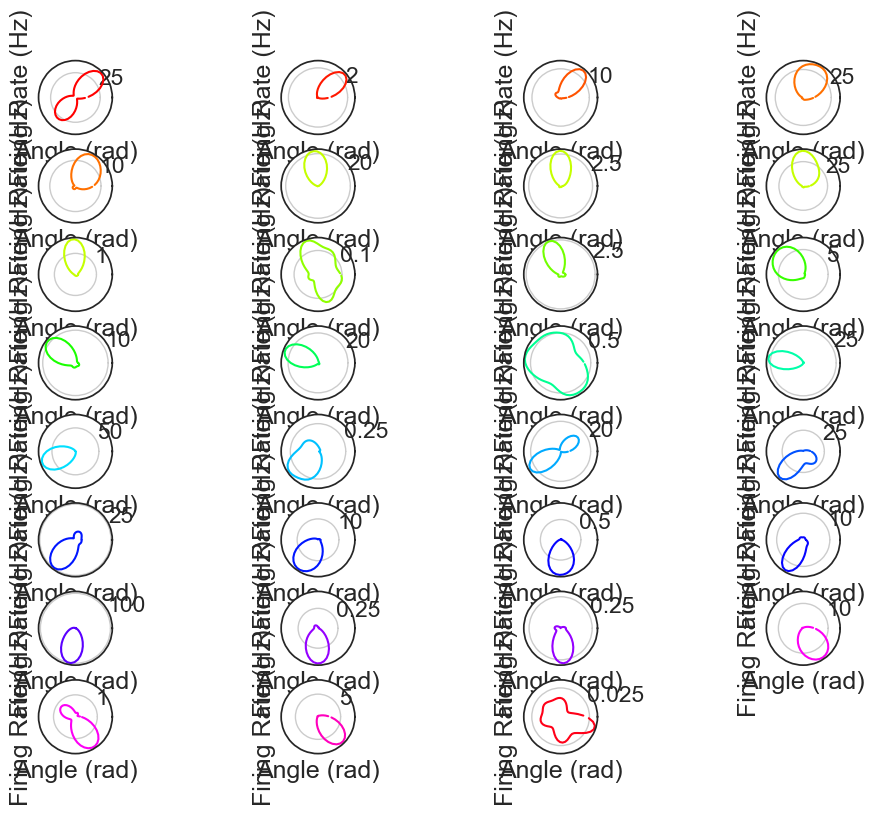

In [15]:
plt.figure(figsize=(12, 9))
for i, n in enumerate(pref_ang.sort_values().index.values):
    plt.subplot(8, 4, i + 1, projection='polar')  # Plot the curves in 8 rows and 4 columns
    plt.plot(
        smoothcurves[n], color=color.loc[n]
    )  # Colour of the curves determined by preferred angle    
    plt.xlabel("Angle (rad)")  # Angle in radian, on the X-axis
    plt.ylabel("Firing Rate (Hz)")  # Firing rate in Hz, on the Y-axis
    plt.xticks([])
plt.show()

Awesome!



***
Decoding
------------------

Now that we have HD tuning curves, we can go one step further. Using only the population activity of ADn units, we can decode the direction the animal is looking in. We will then compare this to the real head direction of the animal, and discover that population activity in the ADn indeed codes for HD.

To decode the population activity, we will be using a Bayesian Decoder as implemented in Pynapple. Just a single line of code!



In [16]:
decoded, proba_feature = nap.decode_1d(
    tuning_curves=tuning_curves,
    group=spikes_adn,
    ep=epochs["wake"],
    bin_size=0.1,  # second
    feature=angle,
)

What does this look like ?



In [17]:
print(decoded)

Time (s)
----------  ---------
8812.35     0.772523
8812.45     0.66952
8812.55     0.463514
8812.65     0.66952
8812.75     0.66952
8812.85     0.66952
8812.95     0.566517
...
10770.65    0.0515015
10770.75    5.92267
10770.85    5.71667
10770.95    5.92267
10771.05    5.92267
10771.15    5.92267
10771.25    5.92267
dtype: float64, shape: (19590,)


The variable 'decoded' indicates the most probable angle in which the animal was looking. There is another variable, 'proba_feature' that denotes the probability of a given angular bin at a given time point. We can look at it below:



In [18]:
print(proba_feature.as_dataframe())

              0.051502  0.154505      0.257508      0.360511      0.463514  \
8812.35   2.199077e-06  0.000223  3.717901e-03  1.769861e-02  7.205101e-02   
8812.45   8.561129e-08  0.000013  1.858017e-03  9.312326e-03  9.216920e-02   
8812.55   4.168300e-04  0.022715  1.916560e-01  1.919596e-01  2.489159e-01   
8812.65   1.082000e-05  0.000156  5.663501e-03  1.973657e-02  1.097107e-01   
8812.75   4.128198e-05  0.001369  2.088684e-02  3.927845e-02  1.338599e-01   
...                ...       ...           ...           ...           ...   
10770.85  6.695624e-05  0.000003  1.968111e-07  1.057744e-07  5.481207e-11   
10770.95  2.924858e-04  0.000005  1.392026e-07  4.800910e-08  1.638920e-10   
10771.05  1.093979e-03  0.000115  1.300380e-05  3.998319e-06  1.464971e-08   
10771.15  5.537065e-03  0.001235  1.198087e-04  2.325507e-05  4.497914e-07   
10771.25  5.969857e-04  0.000058  2.970409e-06  2.588196e-06  3.024315e-09   

              0.566517      0.669520  0.772523      0.875526   

Each row of this pandas DataFrame is a time bin, and each column is an angular bin. The sum of all values in a row add up to 1.

Now, let's plot the raster plot for a given period of time, and overlay the actual and decoded HD on the population activity.



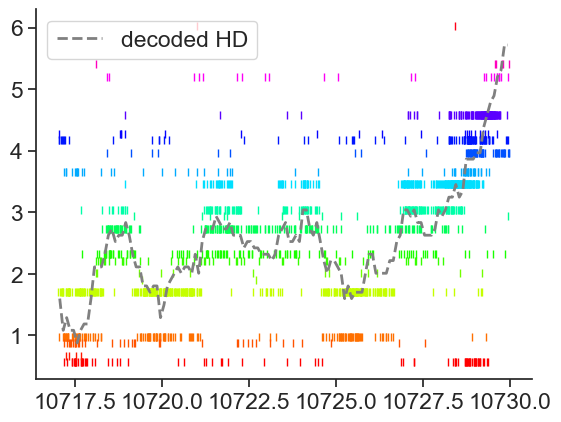

In [21]:
ep = nap.IntervalSet(
    start=10717, end=10730
)  # Select an arbitrary interval for plotting

plt.figure()
plt.rc("font", size=12)
for i, n in enumerate(spikes_adn.keys()):
    plt.plot(
        spikes[n].restrict(ep).fillna(pref_ang[n]), "|", color=color.loc[n]
    )  # raster plot for each cell
plt.plot(
    decoded.restrict(ep), "--", color="grey", linewidth=2, label="decoded HD"
)  # decoded HD
plt.legend(loc="upper left")

plt.savefig("tutorial_HD_dataset.png")

From this plot, we can see that the decoder is able to estimate the head-direction based on the population activity in ADn. Amazing!

What does the probability distribution in this example event look like?
Ideally, the bins with the highest probability will correspond to the bins having the most spikes. Let's plot the probability matrix to visualize this.



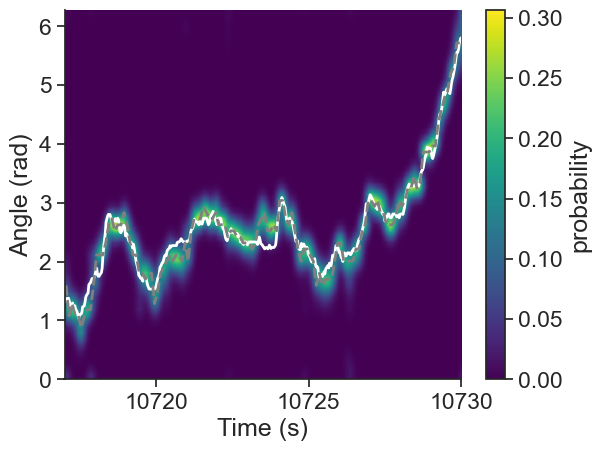

In [20]:
smoothed = scipy.ndimage.gaussian_filter(
    proba_feature, 1
)  # Smoothening the probability distribution

# Create a DataFrame with the smoothed distribution
p_feature = pd.DataFrame(
    index=proba_feature.index.values,
    columns=proba_feature.columns.values,
    data=smoothed,
)
p_feature = nap.TsdFrame(p_feature)  # Make it a Pynapple TsdFrame

plt.figure()
plt.plot(
    angle.restrict(ep), "w", linewidth=2, label="actual HD", zorder=1
)  # Actual HD, in white
plt.plot(
    decoded.restrict(ep), "--", color="grey", linewidth=2, label="decoded HD", zorder=1
)  # Decoded HD, in grey

# Plot the smoothed probability distribution
plt.imshow(
    np.transpose(p_feature.restrict(ep).values),
    aspect="auto",
    interpolation="bilinear",
    extent=[ep["start"][0], ep["end"][0], 0, 2 * np.pi],
    origin="lower",
    cmap="viridis",
)

plt.xlabel("Time (s)")  # X-axis is time in seconds
plt.ylabel("Angle (rad)")  # Y-axis is the angle in radian
plt.colorbar(label="probability")

From this probability distribution, we observe that the decoded HD very closely matches the actual HD. Therefore, the population activity in ADn is a reliable estimate of the heading direction of the animal.

I hope this tutorial was helpful. If you have any questions, comments or suggestions, please feel free to reach out to the Pynapple Team!

